In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Mounted at /content/drive


In [2]:
!unzip -q '/content/drive/MyDrive/Data/Date.zip' -d /content

In [3]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import random
from skimage.transform import resize
import keras
import tensorflow as tf
import gc

from sklearn.metrics import confusion_matrix
from PIL import Image

# Load Data

In [4]:
path_imgs = "/content/images"
path_labels = "/content/labels"
def resize_img(img, target_size=[150, 40, 3]):
    color = (255, 255, 255)
    pass

X, y = [], []
for file in os.listdir(path_imgs):
  #print(file)

  name = file.split('/')[-1]

  name = name.split('.')[0] + '.txt'
  file_path = os.path.join(path_labels, name)
  file_txt = open(file_path, "r")
  # Đọc nội dung
  contents = file_txt.readlines()
  # Đóng file
  file_txt.close()

  X.append(path_imgs + '/'+ file)
  for content in contents:
    content = content.strip()
  y.append(content)


print("Number of samples:", len(y))

X_y = list(zip(X, y))
random.shuffle(X_y)
X, y = zip(*X_y)

Number of samples: 128510


# Thống kế data và hàm chuyển

In [5]:
from keras import layers

max_length = max([len(label) for label in y])
labels = [label.ljust(max_length) for label in y]
characters = set(char for label in y for char in label)

print("Max length: ", max_length)
print("Num of characters: ", len(characters))
print(characters)

characters = sorted(list(characters))
print(characters)

char_to_num = layers.StringLookup(
    vocabulary=list(characters), mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)


Max length:  11
Num of characters:  44
{'E', 'C', 'N', 'p', 'J', 'Y', 'M', 'e', 'g', 'b', 'V', 'G', 'P', 't', 'U', '3', 'n', 'L', '0', 'B', 'A', '8', 'F', 'O', '2', 'a', '/', '1', 'c', 'o', 'y', 'v', 'r', '6', 'R', 'D', '5', 'T', '9', 'S', 'l', 'u', '7', '4'}
['/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'J', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'Y', 'a', 'b', 'c', 'e', 'g', 'l', 'n', 'o', 'p', 'r', 't', 'u', 'v', 'y']


In [6]:
def decode_label(label):
       # Reverse Mapping
    label = num_to_char(label)

    # Join the chars
    label = tf.strings.reduce_join(label).numpy().decode('utf8')

    return label

# Split data

In [7]:
from sklearn.model_selection import train_test_split
X_train, X1, y_train, y1 = train_test_split(X,y, test_size = 0.3, random_state= 44)
num_val = int(float(2/3)*len(y1))
X_test = X1[num_val:]
y_test = y1[num_val:]
X_val = X1[:num_val]
y_val = y1[:num_val]


In [8]:
print("Length train: ", len(y_train), len(X_train))
print("Length val: ", len(y_val), len(X_val))
print("Length test: ", len(y_test), len(X_test))

Length train:  89957 89957
Length val:  25702 25702
Length test:  12851 12851


In [9]:
def encode_image(img_path, label):
  img = tf.io.read_file(img_path)
  img = tf.io.decode_png(img, channels=1)
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = tf.image.resize(img, [64, 224])
  img = tf.transpose(img, perm=[1, 0, 2])
  label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
  return {"image": img, "label": label}

In [10]:
batch_size = 16
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_image, num_parallel_calls=tf.data.AUTOTUNE
    )
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
validation_dataset = (
    validation_dataset.map(
        encode_image, num_parallel_calls=tf.data.AUTOTUNE
    )
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)



In [11]:
def data_visualization(data, model=None, decode_pred=None, GRID=[4, 4], FIGSIZE=(20,8), cmap="binary"):
      # Specify the plotting configurations
  n_rows, n_cols = GRID
  plt.figure(figsize=FIGSIZE)

  # Get the images and labels from the data
  data = next(iter(data))
  images, labels = data["image"], data["label"]

  if model is not None:
      pred_labels = decode_pred(model.predict(images))

  # Iterate over the data
  for image_number, (image, label) in enumerate(zip(images, labels)):

      if model is not None:
          title = f"True : {decode_label(label)}\nPred : {pred_labels[image_number]}"
      else:
          title = decode_label(label)

      plt.subplot(n_rows, n_cols, image_number + 1)
      plt.imshow(tf.transpose(tf.squeeze(image)), cmap=cmap)
      plt.axis('off')
      plt.title(title)

  plt.show()

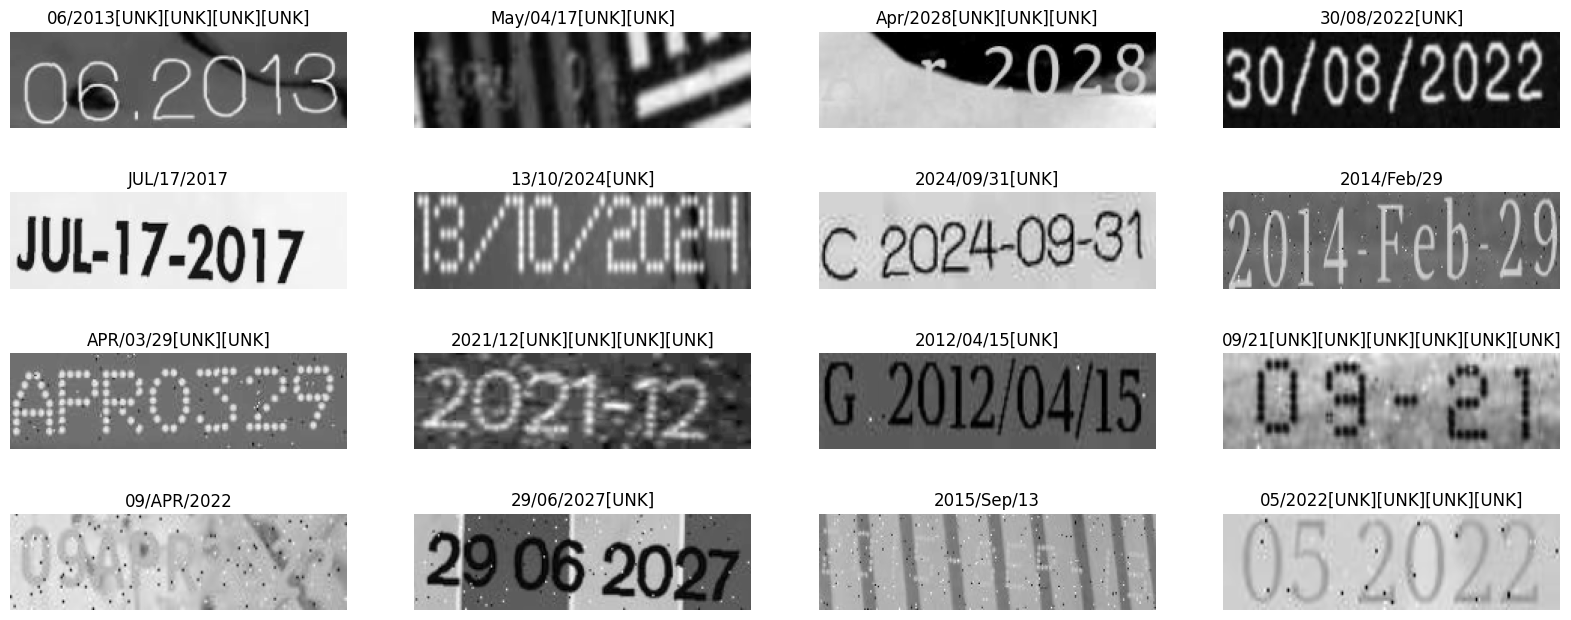

In [12]:
data_visualization(data=train_dataset)

In [13]:
#building the model
from keras import layers
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model

img_width, img_height= 224, 64
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred



def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(224, 64, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # x = layers.Conv2D(
    #     32,
    #     (3, 3),
    #     activation="relu",
    #     kernel_initializer="he_normal",
    #     padding="same",
    #     name="Conv3",
    # )(input_img)
    # x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # # Second conv block
    # x = layers.Conv2D(
    #     32,
    #     (3, 3),
    #     activation="relu",
    #     kernel_initializer="he_normal",
    #     padding="same",
    #     name="Conv4",
    # )(x)
    # x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    timesteps = x.shape[2] * x.shape[3]  # You can adjust this value based on your specific use case
    input_dim = x.shape[1]
    x = layers.Reshape(target_shape=(input_dim, timesteps))(x)

    # x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(256, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model

# Get the model
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 224, 64, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 224, 64, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 112, 32, 32)  0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 112, 32, 32)  9248        ['pool1[0][0]']       

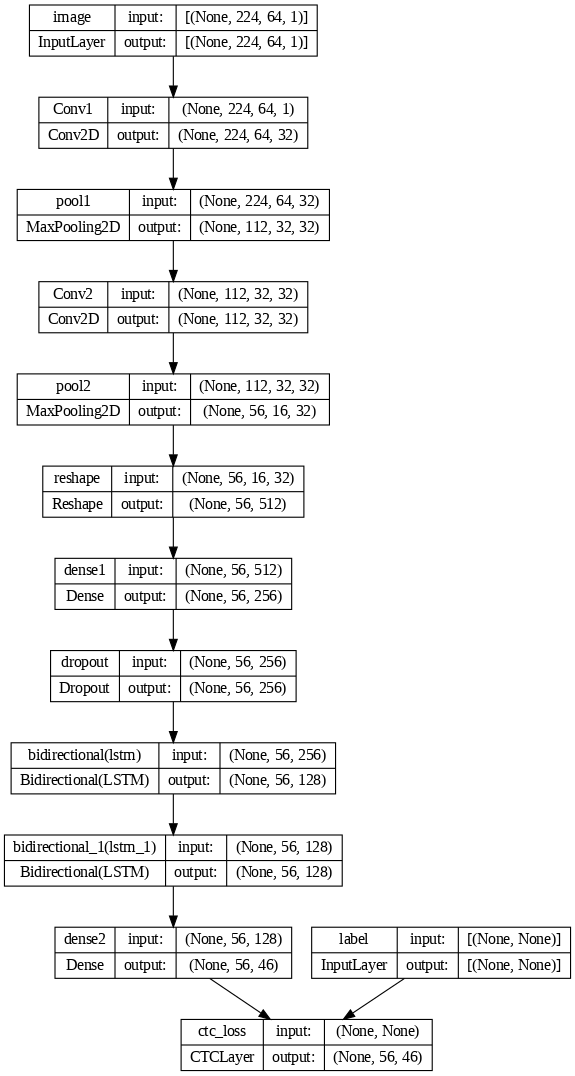

In [14]:
from tensorflow.keras import callbacks
from tensorflow.keras.utils import plot_model

plot_model(model=model, to_file="OCRCaptchModel.png", show_layer_names=True, show_shapes=True, dpi=80)


In [15]:
print("GPU Available:", tf.config.list_physical_devices("GPU"))


GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [16]:
epochs = 100
with tf.device('/GPU:0'):
  history = model.fit(
      train_dataset,
      validation_data = validation_dataset,
      epochs= epochs,
      callbacks=[
          callbacks.EarlyStopping(patience=10, restore_best_weights=True),
          callbacks.ModelCheckpoint(
                filepath="best_model.h5",  # Đường dẫn và tên tệp lưu model
                save_best_only=True),
      ]
  )

Epoch 1/100
5623/5623 [==============================] - 273s 46ms/step - loss: 18.2041 - val_loss: 11.5029
Epoch 2/100
5623/5623 [==============================] - 238s 42ms/step - loss: 8.8766 - val_loss: 5.8125
Epoch 3/100
5623/5623 [==============================] - 241s 43ms/step - loss: 5.9584 - val_loss: 4.1593
Epoch 4/100
5623/5623 [==============================] - 240s 43ms/step - loss: 5.8209 - val_loss: 6.6328
Epoch 5/100
5623/5623 [==============================] - 238s 42ms/step - loss: 5.0172 - val_loss: 4.0852
Epoch 6/100
5623/5623 [==============================] - 237s 42ms/step - loss: 4.0578 - val_loss: 2.9662
Epoch 7/100
5623/5623 [==============================] - 240s 43ms/step - loss: 3.8218 - val_loss: 3.0670
Epoch 8/100
5623/5623 [==============================] - 238s 42ms/step - loss: 3.4507 - val_loss: 2.4358
Epoch 9/100
5623/5623 [==============================] - 239s 42ms/step - loss: 3.0282 - val_loss: 3.8444
Epoch 10/100
5623/5623 [====================

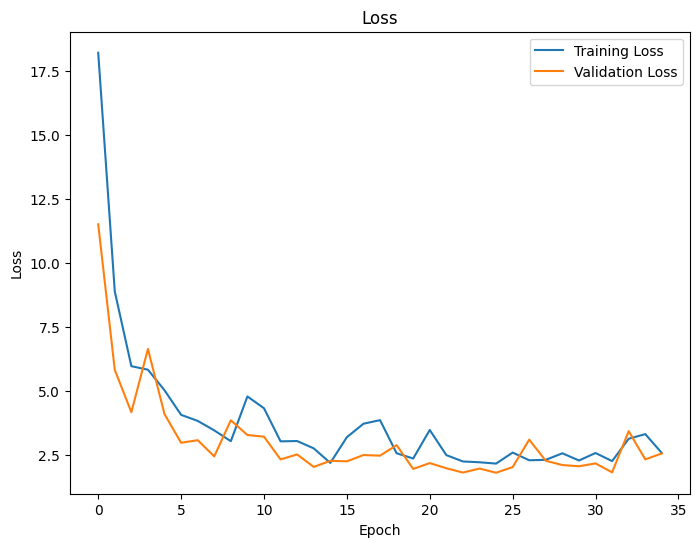

In [17]:
import matplotlib.pyplot as plt

# Lấy giá trị loss và độ chính xác từ history
loss = history.history['loss']
val_loss = history.history['val_loss']


# Vẽ biểu đồ loss
plt.figure(figsize=(8, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [18]:
  # We need a different model for making predictions
ocr_pred_model = keras.Model(
    inputs=model.get_layer("image").input,
    outputs=model.get_layer('dense2').output
)

# Model Summary
ocr_pred_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 224, 64, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 224, 64, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 32, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 112, 32, 32)       9248      
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 16, 32)        0         
                                                                 
 reshape (Reshape)           (None, 56, 512)           0         
                                                                 
 dense1 (Dense)              (None, 56, 256)           131328

In [19]:
def decode_pred(pred_label):
  # Input length
  input_len = np.ones(shape=pred_label.shape[0]) * pred_label.shape[1]

  # CTC decode
  decode = keras.backend.ctc_decode(pred_label, input_length=input_len, greedy=True)[0][0][:,:max_length]

  # Converting numerics back to their character values
  chars = num_to_char(decode)

  # Join all the characters
  texts = [tf.strings.reduce_join(inputs=char).numpy().decode('UTF-8') for char in chars]

  # Remove the unknown token
  filtered_texts = [text.replace('[UNK]', " ").strip() for text in texts]

  return filtered_texts

In [20]:
def encode_image_test(img_path, label):
  img = tf.io.read_file(img_path)
  img = tf.io.decode_png(img, channels=1)
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = tf.image.resize(img, [64, 224])
  img = tf.transpose(img, perm=[1, 0, 2])
  return {"image": img, "label": label}

In [21]:
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = (
    test_dataset.map(
        encode_image_test, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(len(X_test))
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [22]:
import tensorflow as tf

# Xoay ảnh qua bên trái
def rotate_image_left(image):
    rotated_image = tf.image.rot90(image, k=-1)  # Xoay ảnh 90 độ theo chiều kim đồng hồ
    rotated_image = tf.image.rot90(rotated_image, k=2)  # Xoay ảnh 180 độ
    # rotated_image = tf.image.rot90(rotated_image, k=2)
    return rotated_image

In [23]:
data = next(iter(test_dataset))
images = data['image']
labels = data['label']
images.shape[0]

12851

In [ ]:
# Make Prediction
data = next(iter(test_dataset))
images = data['image']
labels = data['label']
model_pred_test = []
# Make Prediction
for i in range(0,images.shape[0]):
  model_pred = ocr_pred_model.predict(tf.expand_dims(images[i], axis=0))
  model_pred_test.append(model_pred)


In [25]:
model_pred_test[0].shape

(1, 56, 46)

In [26]:
print(f"Predicted Label : {decode_pred(model_pred_test[0])[0]}")

Predicted Label : 2028/11/08


In [27]:
from PIL import Image

# # Decode the model prediction.
# print(f"Predicted Label : {decode_pred(model_pred)[0]}")
# print(f"True Label : {text}")

labels_true = []
labels_predict = []
image_test = []
for i in range(0,images.shape[0]):
  array = labels[i].numpy()
  # Giải mã mảng thành chuỗi văn bản
  text = array.decode('utf-8')
  labels_true.append(text)
  # print(f"Predicted Label : {decode_pred(model_pred_test[i])}")
  labels_predict.append(decode_pred(model_pred_test[i])[0])

  # Xoay ảnh qua bên trái
  rotated_image = rotate_image_left(images[i])
  img = rotated_image.numpy()
  flipped_image = np.flipud(img)
  image_test.append(flipped_image)



In [28]:
labels_true = np.array(labels_true)
labels_predict = np.array(labels_predict)
image_test = np.array(image_test)

ValueError: ignored

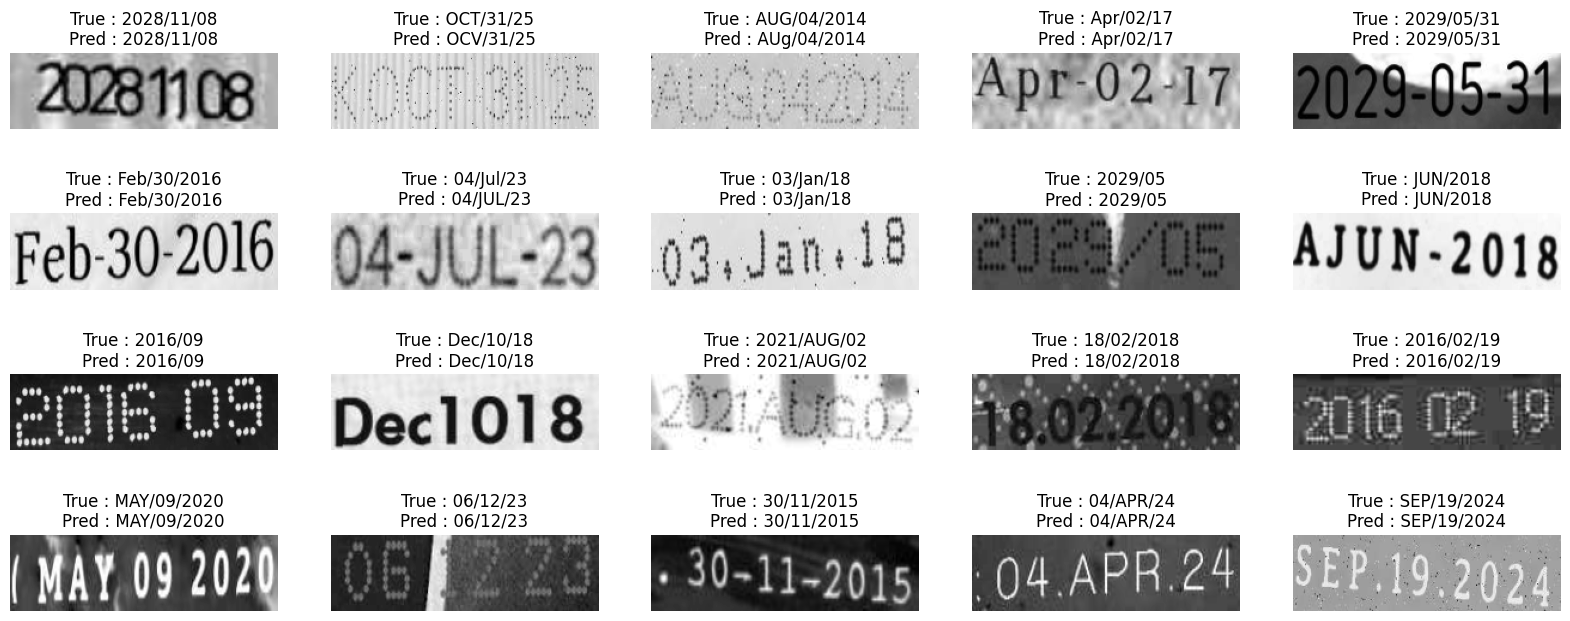

In [29]:
n_rows, n_cols = [4, 5]
plt.figure(figsize=(20,8))

# Get the images and labels from the data
data = next(iter(test_dataset))
images, labels = data["image"], data["label"]

# Iterate over the data
for image_number, (image, label) in enumerate(zip(images, labels)):
    title = f"True : {labels_true[image_number]}\nPred : {labels_predict[image_number]}"

    plt.subplot(n_rows, n_cols, image_number + 1)
    plt.imshow(tf.transpose(tf.squeeze(image)), cmap="gray")
    plt.axis('off')
    plt.title(title)

plt.show()

In [30]:
pip install python-levenshtein

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 43.4 MB/s eta 0:00:00


In [31]:
import Levenshtein

def calculate_cer(predictions, labels):
    total_chars = 0
    total_errors = 0

    for pred, label in zip(predictions, labels):
        pred = pred.strip()
        label = label.strip()
        total_chars += len(label)
        total_errors += Levenshtein.distance(pred, label)
    print(f"Số lượng kí tự lỗi:{total_errors}")
    print(f"Số lượng kí tự:{total_chars}")
    cer = total_errors / total_chars
    return cer

def calculate_wer(predictions, labels):
    total_words = 0
    total_errors = 0
    i = 0
    index = []
    for pred, label in zip(predictions, labels):
        pred_words = pred.strip().split()
        label_words = label.strip().split()
        if (Levenshtein.distance(pred_words, label_words) !=0):
          index.append(i)
        total_words += len(label_words)
        total_errors += Levenshtein.distance(pred_words, label_words)
        i+=1
    print(f"Số lượng chuỗi lỗi:{total_errors}")
    print(f"Số lượng chuỗi:{total_words}")
    wer = total_errors / total_words
    return wer, index

# Tính CER và WER
cer = calculate_cer(labels_predict, labels_true)
wer, index = calculate_wer(labels_predict, labels_true)
index = np.array(index)
print("CER:", cer)
print("WER:", wer)


Số lượng kí tự lỗi:6573
Số lượng kí tự:116032
Số lượng chuỗi lỗi:2487
Số lượng chuỗi:12851
CER: 0.056648166023166024
WER: 0.19352579565792546


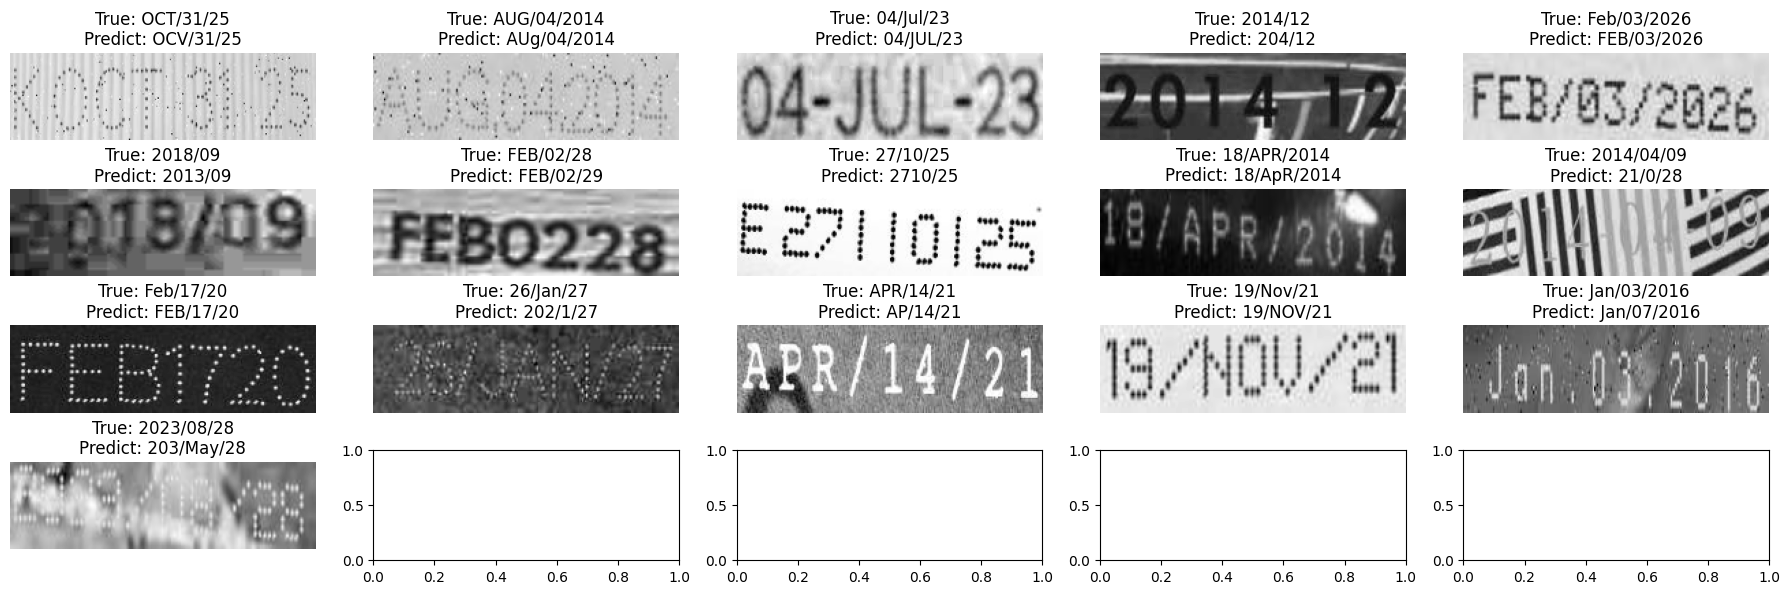

In [32]:
n_rows = 4
n_cols = 5

fig, axs = plt.subplots(n_rows, n_cols, figsize=(18, 6))

for i, image_number in enumerate(index):
    rotated_image = rotate_image_left(images[image_number])
    img = rotated_image.numpy()
    flipped_image = np.flipud(img)

    true_label = labels_true[image_number]
    predict_label = labels_predict[image_number]

    row = i // n_cols
    col = i % n_cols

    title = f"True: {true_label}\nPredict: {predict_label}"

    axs[row, col].imshow(flipped_image, cmap='gray')
    axs[row, col].axis('off')
    axs[row, col].set_title(title)
    if row == n_rows - 1:
      break
plt.tight_layout()
plt.show()
